Exploratory data analysis of GOSAT-OCO-2 collocations - this code may need some cleaing up

Laurel Hopkins Manella 7/29/25

In [95]:
import numpy as np
import pandas as pd
import xarray as xr
import dask
import matplotlib.pyplot as plt
import utils

In [2]:
# PC -- run this

# define data paths -- PC paths
plot_dir  = 'C:\\Users\\hopki\\Projects\\gosat_oco2\\plots\\'
fn =  'C:\\Users\\hopki\\Projects\\gosat_oco2\\match_gosat_v9_oco2_v11.1_20140906_20200630_time2_lat2_lon3_min3_dist300_max100_closest.nc' 
# '/data8/ttaylor/data_ttaylor/gosat_oco2_collocations/match_gosat_v9_oco2_v11.1_20140906_20200630_LiteDirect_2hrs_300km_2degLat_3degLon_3-100soundings_closest.hdf'

In [3]:
colloc_data_xr = xr.open_dataset(fn)
colloc_data = colloc_data_xr.to_dataframe()
colloc_data['gosat_sounding_id'] = colloc_data.index
colloc_data

,gosat_year,gosat_month,gosat_day,gosat_hour,gosat_minute,gosat_second,gosat_latitude,gosat_longitude,gosat_xco2,gosat_xco2_uncertainty,...,oco2_pressure_levels17,oco2_pressure_levels18,oco2_pressure_levels19,oco2_xco2_mean,oco2_xco2_median,oco2_xco2_std,num_total_collocations,num_saved_collocations,matched_tccon,gosat_sounding_id
gosat_sounding_id,,,,,,,,,,,,,,,,,,,,,
20140906040642,2014,9,6,4,6,42,-17.431341,128.038544,396.764526,0.897655,...,869.159119,920.286133,971.413147,395.436523,395.444794,0.403076,343,100,NaN,20140906040642
20140906040647,2014,9,6,4,6,47,-18.031874,130.485947,397.638000,0.903635,...,868.645203,919.742065,970.838806,395.603058,395.642578,0.366067,876,100,NaN,20140906040647
20140906040652,2014,9,6,4,6,52,-18.011812,130.488754,397.922119,0.890935,...,868.748169,919.851074,970.953857,395.605652,395.646057,0.359193,868,100,NaN,20140906040652
20140906040656,2014,9,6,4,6,56,-18.005028,130.488266,398.099762,0.862899,...,868.818848,919.925903,971.032837,395.610901,395.648163,0.357216,865,100,NaN,20140906040656
20140906040701,2014,9,6,4,7,1,-20.559467,129.964844,395.433105,0.999376,...,865.693420,916.616577,967.539734,395.306396,395.269012,0.300312,1590,100,NaN,20140906040701
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20200630202157,2020,6,30,20,21,57,36.498730,-108.255020,410.592102,0.890073,...,720.933533,763.341431,805.749268,411.348511,411.352417,0.326544,1208,100,NaN,20200630202157
20200630202206,2020,6,30,20,22,6,36.504108,-108.256424,410.843719,1.091068,...,720.731567,763.127563,805.523560,411.336182,411.339966,0.310582,1209,100,NaN,20200630202206
20200630202211,2020,6,30,20,22,11,33.975773,-108.854935,412.086700,0.972689,...,719.213196,761.519836,803.826477,413.397308,413.396301,0.721854,1216,100,NaN,20200630202211


In [7]:
# Calculate dtime

# OCO-2
temp_df = colloc_data[['oco2_year', 'oco2_month', 'oco2_day',
                       'oco2_hour', 'oco2_minute', 'oco2_second']]
temp_df.columns = ('year', 'month', 'day', 'hour', 'minute', 'second')
temp_df = temp_df.astype({'year': 'int', 'month': 'int', 'day': 'int', 'hour': 'int',
                         'minute': 'int', 'second': 'int'})
temp_df['datetime'] = pd.to_datetime(temp_df[['year', 'month', 'day',
                                             'hour', 'minute', 'second']])
colloc_data['oco2_datetime'] = temp_df['datetime']

# GOSAT
temp_df2 = colloc_data[['gosat_year', 'gosat_month', 'gosat_day',
                       'gosat_hour', 'gosat_minute', 'gosat_second']]
temp_df2.columns = ('year', 'month', 'day', 'hour', 'minute', 'second')
temp_df2 = temp_df2.astype({'year': 'int', 'month': 'int', 'day': 'int', 'hour': 'int',
                         'minute': 'int', 'second': 'int'})
temp_df2['datetime'] = pd.to_datetime(temp_df2[['year', 'month', 'day',
                                             'hour', 'minute', 'second']])
colloc_data['gosat_datetime'] = temp_df2['datetime']

dtime = (colloc_data['oco2_datetime'] - colloc_data['gosat_datetime']).dt.total_seconds() / 60
dtime = dtime.values

colloc_data.loc[:,['dtime']] = dtime

In [8]:
# Filter collocations

c = np.pi / 180  # for converting degrees to radians

dtime_max = 2.0 * 60 # time difference in minutes
max_dlat  = 2.0  # latitude difference in deg
max_dlon  = 3.0  # longitude difference in deg
max_dist = 300.0  # max distance in km

colloc_data.loc[:,['dlat']] = colloc_data['gosat_latitude'].values - colloc_data['oco2_latitude'].values
colloc_data.loc[:,['dlon']] = utils.longitude_difference(colloc_data['gosat_longitude'].values-colloc_data['oco2_longitude'].values, None)
colloc_data.loc[:,['dist']] = np.sqrt(colloc_data['dlat'].values**2 + np.cos(c * colloc_data['gosat_latitude'].values) * 
                                      np.cos(c * colloc_data['oco2_latitude'].values) * colloc_data['dlon'].values**2) * 111.1  # distance in km

num_total_collocations = len(colloc_data.index.unique())

oco2_mask = np.logical_and.reduce((colloc_data['oco2_xco2'].values >= 300,
                                   colloc_data['oco2_xco2'].values <= 900,
                                   colloc_data['oco2_xco2_quality_flag'] == 0, # all collocated data is already filtered w/ the quality flag
                                   np.abs(colloc_data['dlat'].values) <= max_dlat,  
                                   np.abs(colloc_data['dlon'].values) <= max_dlon,  
                                   np.abs(colloc_data['dist'].values) <= max_dist,
                                   np.abs(colloc_data['dtime'].values) <= dtime_max))  

colloc_data_filtered = colloc_data.iloc[oco2_mask]
num_good_collocations = len(colloc_data_filtered.index.unique())
print(f'Number of good OCO2 collocations: {num_good_collocations} ({round(num_good_collocations/num_total_collocations * 100,2)}%)')

Number of good OCO2 collocations: 203329 (99.9%)


In [9]:
lon_mask = np.abs(colloc_data['dlon'].values) <= max_dlon
np.where(lon_mask == False)[0]

array([ 13153,  13154,  13155,  16120,  18813,  27728,  31651,  37640,
        38677,  38678,  39687,  39688,  40856,  57243,  67516,  67956,
        67957,  68624,  68625,  73476,  73477,  78185,  78186,  78187,
        80479,  81739,  84019,  86440,  86441,  86442,  86443,  86444,
        86445,  87722,  90832,  90833,  90834,  90835,  90836,  90837,
        90838,  91575,  93016,  93017,  93018,  93019,  99445, 103406,
       103407, 103408, 104119, 105407, 116596, 117271, 117272, 120837,
       120838, 120839, 121362, 127599, 127600, 138780, 138781, 139121,
       139122, 146086, 146087, 146088, 151542, 156303, 163330, 179228,
       188601, 191445, 192369, 197242, 197243])

In [10]:
dist_mask = np.abs(colloc_data['dist'].values) <= max_dist
np.where(dist_mask == False)[0]

array([ 13153,  13154,  13155,  16120,  18813,  27728,  31651,  37640,
        38677,  38678,  39687,  39688,  40856,  57243,  67516,  67956,
        67957,  68624,  68625,  73476,  73477,  78185,  78186,  78187,
        80479,  81739,  84019,  86440,  86441,  86442,  86443,  86444,
        86445,  87722,  90832,  90833,  90834,  90835,  90836,  90837,
        90838,  91575,  93016,  93017,  93018,  93019,  99445, 103406,
       103407, 103408, 104119, 105407, 116596, 117271, 117272, 120837,
       120838, 120839, 121362, 127599, 127600, 138780, 138781, 139121,
       139122, 146086, 146087, 146088, 151542, 156303, 163330, 179228,
       188601, 191445, 192369, 197242, 197243])

In [11]:
# Define masks for plotting 

h_gain = b'H'  
m_gain = b'M'

gosat_land = colloc_data_filtered['gosat_retrieval_surface_type'].values == 1
gosat_gain = colloc_data_filtered['gosat_gain'].values

landH_mask = np.logical_and(gosat_land, gosat_gain == h_gain)
landM_mask = np.logical_and(gosat_land, gosat_gain == m_gain)
oceanH_mask = np.logical_and(~gosat_land, gosat_gain == h_gain)
land_mask = gosat_land 

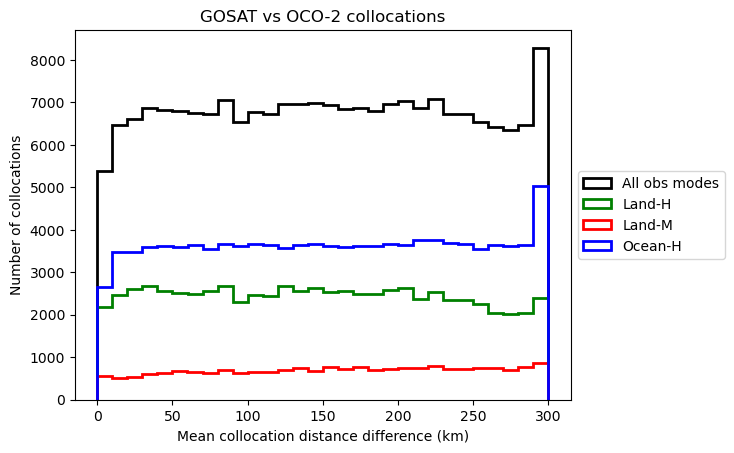

In [12]:
# Mean collocation distance

plt.hist(colloc_data_filtered['dist'].values, bins=30, fill=False, histtype='step', edgecolor='black', linewidth=2, label='All obs modes')
plt.hist(colloc_data_filtered['dist'].values[landH_mask], bins=30, fill=False, histtype='step', edgecolor='green', linewidth=2, label='Land-H')
plt.hist(colloc_data_filtered['dist'].values[landM_mask], bins=30, fill=False, histtype='step', edgecolor='red', linewidth=2, label='Land-M')
plt.hist(colloc_data_filtered['dist'].values[oceanH_mask], bins=30, fill=False, histtype='step', edgecolor='blue', linewidth=2, label='Ocean-H')

plt.title('GOSAT vs OCO-2 collocations')
plt.xlabel('Mean collocation distance difference (km)')
plt.ylabel('Number of collocations')
#plt.legend(loc='upper left')
ax = plt.subplot()
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

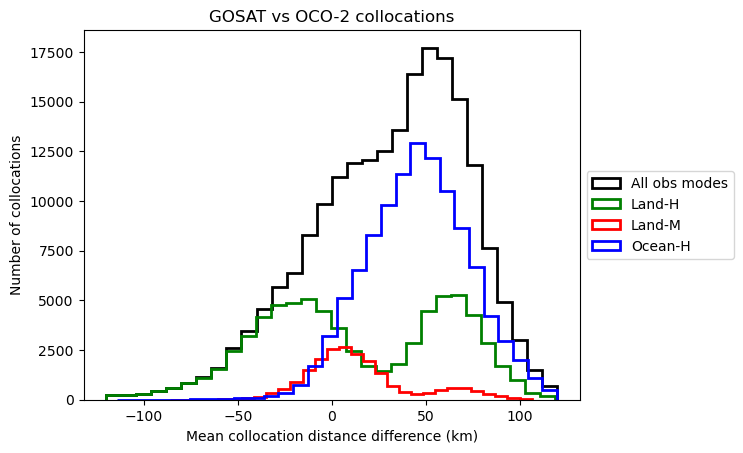

In [14]:
# Mean collocation time difference

plt.hist(colloc_data_filtered['dtime'].values, bins=30, fill=False, histtype='step', edgecolor='black', linewidth=2, label='All obs modes')
plt.hist(colloc_data_filtered['dtime'].values[landH_mask], bins=30, fill=False, histtype='step', edgecolor='green', linewidth=2, label='Land-H')
plt.hist(colloc_data_filtered['dtime'].values[landM_mask], bins=30, fill=False, histtype='step', edgecolor='red', linewidth=2, label='Land-M')
plt.hist(colloc_data_filtered['dtime'].values[oceanH_mask], bins=30, fill=False, histtype='step', edgecolor='blue', linewidth=2, label='Ocean-H')

plt.title('GOSAT vs OCO-2 collocations')
plt.xlabel('Mean collocation time difference (minutes)')
plt.ylabel('Number of collocations')
#plt.legend(loc='upper left')
ax = plt.subplot()
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [15]:
# Correct for different CO2 priors 
gosat_prior = colloc_data_filtered[colloc_data_filtered.columns[colloc_data_filtered.columns.str.startswith('gosat_co2_profile_apriori')]].values  # 20 x 123
gosat_h = colloc_data_filtered[colloc_data_filtered.columns[colloc_data_filtered.columns.str.startswith('gosat_pressure_weight')]].values
gosat_a = colloc_data_filtered[colloc_data_filtered.columns[colloc_data_filtered.columns.str.startswith('gosat_xco2_averaging_kernel')]].values
oco2_prior = colloc_data_filtered[colloc_data_filtered.columns[colloc_data_filtered.columns.str.startswith('oco2_co2_profile_apriori')]].values
oco2_h = colloc_data_filtered[colloc_data_filtered.columns[colloc_data_filtered.columns.str.startswith('oco2_pressure_weight')]].values
oco2_a = colloc_data_filtered[colloc_data_filtered.columns[colloc_data_filtered.columns.str.startswith('oco2_xco2_averaging_kernel')]].values

# CO2 prior and AK corrections
# Former as in Eq A10 in [Wunch, ACP, 2010]. Also equivelant to Eq 3 in [Taylor, AMT, 2023].
# The sum of the two terms yields the total correction to GOSAT XCO2 to harmonize it to OCO-2.
true_profile = oco2_prior
colloc_data_filtered.loc[:,['xco2_prior_adj_a']] = np.sum(gosat_h * (gosat_a - 1) * (gosat_prior - true_profile), axis=1)
colloc_data_filtered.loc[:,['xco2_prior_adj_b']] = np.sum(gosat_h * (gosat_a - oco2_a) * (gosat_prior - true_profile), axis=1)

In [38]:
# Calcualte dxco2 (our y variable)

xco2_bc_diff = colloc_data_filtered['gosat_xco2'].values - colloc_data_filtered['oco2_xco2'].values
colloc_data_filtered.loc[:,['dxco2']] = xco2_bc_diff

if correct_ak:
  print('Implementing the AK correction to XCO2 to account for the different CO2 priors and smoothing.')
  if two_term_ak:
    # Two-term AK correction
    print('Performing two-term AK correction')
    colloc_data_filtered.loc[:,['dxco2_corrected']] = xco2_bc_diff + colloc_data_filtered['xco2_prior_adj_a'] + colloc_data_filtered['xco2_prior_adj_b']
  else:
    # Single-term AK correction
    print('Performing single-term AK correction')
    colloc_data_filtered.loc[:,['dxco2_corrected']] = xco2_bc_diff + colloc_data_filtered['xco2_prior_adj_b']
else:
  colloc_data_filtered.loc[:,['dxco2_corrected']] = xco2_bc_diff

print(f'Min: {colloc_data_filtered['dxco2_corrected'].min():.6f}')
print(f'Max: {colloc_data_filtered['dxco2_corrected'].max():.6f}')
print(f'Mean: {colloc_data_filtered['dxco2_corrected'].mean():.6f}')
print(f'Median: {np.median(colloc_data_filtered['dxco2_corrected']):.6f}')
print(f'Std: {colloc_data_filtered['dxco2_corrected'].std():.6f}')

Implementing the AK correction to XCO2 to account for the different CO2 priors and smoothing.
Performing single-term AK correction
Min: -10.298220
Max: 10.771373
Mean: -0.189527
Median: -0.205785
Std: 1.227294


In [29]:
# Compute monthly medians for xco2_prior_adj_a and xco2_prior_adj_b
# retrieval_surface_type: 1 = land, 0 = ocean
# gain h_gain = b'H', m_gain = b'M'
columns = ['year', 'month', 'xco2_prior_adj_a_monthly_median', 'xco2_prior_adj_b_monthly_median']
monthly_medians_all_modes = pd.DataFrame(columns=columns)
monthly_medians_land_h = pd.DataFrame(columns=columns)
monthly_medians_land_m = pd.DataFrame(columns=columns)
monthly_medians_ocean_h = pd.DataFrame(columns=columns)

for year in colloc_data_filtered['gosat_year'].unique():
  yearly_df = colloc_data_filtered[colloc_data_filtered['gosat_year'] == year]
  a = yearly_df.groupby(['gosat_month'])['xco2_prior_adj_a'].median()
  b = yearly_df.groupby(['gosat_month'])['xco2_prior_adj_b'].median()
  annual_medians = pd.DataFrame(np.array([np.repeat(year, a.shape[0]), np.array(a.index), a.values, b.values]).T, columns=columns)
  monthly_medians_all_modes = pd.concat([monthly_medians, annual_medians], ignore_index=True)

land_h_df = colloc_data_filtered[(colloc_data_filtered['gosat_retrieval_surface_type'] == 1)  & (colloc_data_filtered['gosat_gain'] == b'H')]
for year in land_h_df['gosat_year'].unique():
  yearly_df = land_h_df[land_h_df['gosat_year'] == year]
  a = yearly_df.groupby(['gosat_month'])['xco2_prior_adj_a'].median()
  b = yearly_df.groupby(['gosat_month'])['xco2_prior_adj_b'].median()
  annual_medians = pd.DataFrame(np.array([np.repeat(year, a.shape[0]), np.array(a.index), a.values, b.values]).T, columns=columns)
  monthly_medians_land_h = pd.concat([monthly_medians, annual_medians], ignore_index=True)

land_m_df = colloc_data_filtered[(colloc_data_filtered['gosat_retrieval_surface_type'] == 1) & (colloc_data_filtered['gosat_gain'] == b'M')]
for year in land_m_df['gosat_year'].unique():
  yearly_df = land_m_df[land_m_df['gosat_year'] == year]
  a = yearly_df.groupby(['gosat_month'])['xco2_prior_adj_a'].median()
  b = yearly_df.groupby(['gosat_month'])['xco2_prior_adj_b'].median()
  annual_medians = pd.DataFrame(np.array([np.repeat(year, a.shape[0]), np.array(a.index), a.values, b.values]).T, columns=columns)
  monthly_medians_land_m = pd.concat([monthly_medians, annual_medians], ignore_index=True)
    
ocean_h_df = colloc_data_filtered[(colloc_data_filtered['gosat_retrieval_surface_type'] == 0) & (colloc_data_filtered['gosat_gain'] == b'H')]
for year in ocean_h_df['gosat_year'].unique():
  yearly_df = ocean_h_df[ocean_h_df['gosat_year'] == year]
  a = yearly_df.groupby(['gosat_month'])['xco2_prior_adj_a'].median()
  b = yearly_df.groupby(['gosat_month'])['xco2_prior_adj_b'].median()
  annual_medians = pd.DataFrame(np.array([np.repeat(year, a.shape[0]), np.array(a.index), a.values, b.values]).T, columns=columns)
  monthly_medians_ocean_h = pd.concat([monthly_medians, annual_medians], ignore_index=True)

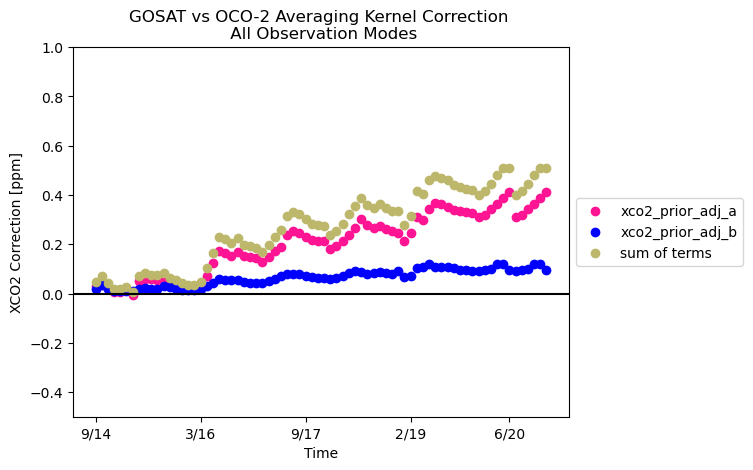

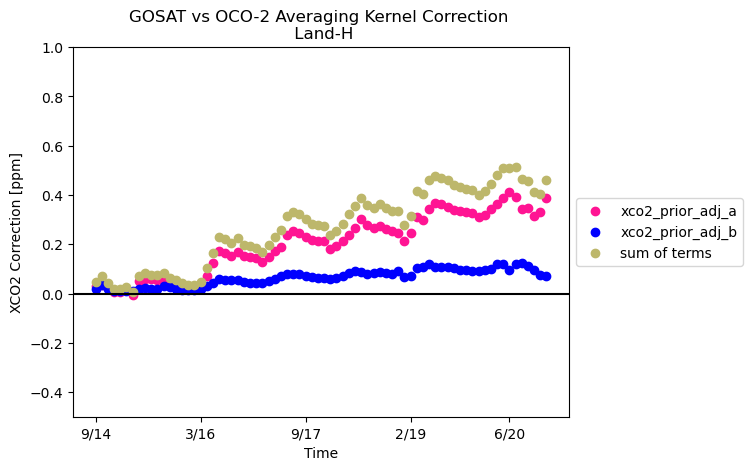

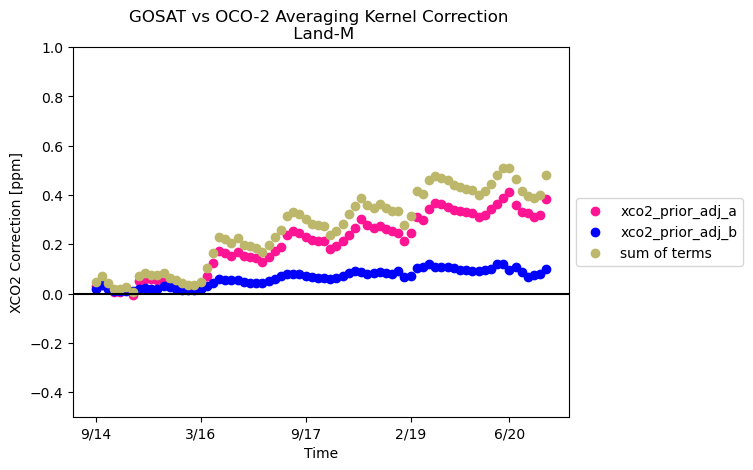

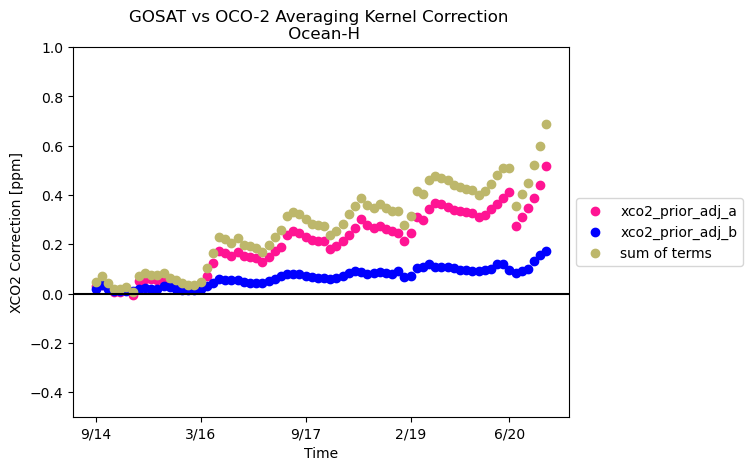

In [62]:
# All modes
plt.scatter(monthly_medians_all_modes.index, monthly_medians_all_modes['xco2_prior_adj_a_monthly_median'].values, label='xco2_prior_adj_a', color='deeppink')
plt.scatter(monthly_medians_all_modes.index, monthly_medians_all_modes['xco2_prior_adj_b_monthly_median'].values, label='xco2_prior_adj_b', color='blue')
plt.scatter(monthly_medians_all_modes.index, monthly_medians_all_modes['xco2_prior_adj_a_monthly_median'].values + monthly_medians_all_modes['xco2_prior_adj_b_monthly_median'].values, label='sum of terms', color='darkkhaki')
plt.axhline(0, color='black')

plt.title('GOSAT vs OCO-2 Averaging Kernel Correction \n All Observation Modes')
plt.xlabel('Time')
plt.ylabel('XCO2 Correction [ppm]')
plt.xticks([0, 17, 34, 51, 67], ['9/14', '3/16', '9/17', '2/19', '6/20'])
ax = plt.subplot()
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_ylim(-0.5, 1.0)
plt.show()

# Land-H
plt.scatter(monthly_medians_land_h.index, monthly_medians_land_h['xco2_prior_adj_a_monthly_median'].values, label='xco2_prior_adj_a', color='deeppink')
plt.scatter(monthly_medians_land_h.index, monthly_medians_land_h['xco2_prior_adj_b_monthly_median'].values, label='xco2_prior_adj_b', color='blue')
plt.scatter(monthly_medians_land_h.index, monthly_medians_land_h['xco2_prior_adj_a_monthly_median'].values + monthly_medians_land_h['xco2_prior_adj_b_monthly_median'].values, label='sum of terms', color='darkkhaki')
plt.axhline(0, color='black')

plt.title('GOSAT vs OCO-2 Averaging Kernel Correction \n Land-H')
plt.xlabel('Time')
plt.ylabel('XCO2 Correction [ppm]')
plt.xticks([0, 17, 34, 51, 67], ['9/14', '3/16', '9/17', '2/19', '6/20'])
ax = plt.subplot()
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_ylim(-0.5, 1.0)
plt.show()

# Land-M
plt.scatter(monthly_medians_land_m.index, monthly_medians_land_m['xco2_prior_adj_a_monthly_median'].values, label='xco2_prior_adj_a', color='deeppink')
plt.scatter(monthly_medians_land_m.index, monthly_medians_land_m['xco2_prior_adj_b_monthly_median'].values, label='xco2_prior_adj_b', color='blue')
plt.scatter(monthly_medians_land_m.index, monthly_medians_land_m['xco2_prior_adj_a_monthly_median'].values + monthly_medians_land_m['xco2_prior_adj_b_monthly_median'].values, label='sum of terms', color='darkkhaki')
plt.axhline(0, color='black')

plt.title('GOSAT vs OCO-2 Averaging Kernel Correction \n Land-M')
plt.xlabel('Time')
plt.ylabel('XCO2 Correction [ppm]')
plt.xticks([0, 17, 34, 51, 67], ['9/14', '3/16', '9/17', '2/19', '6/20'])
ax = plt.subplot()
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_ylim(-0.5, 1.0)
plt.show()

# Ocean-H
plt.scatter(monthly_medians_ocean_h.index, monthly_medians_ocean_h['xco2_prior_adj_a_monthly_median'].values, label='xco2_prior_adj_a', color='deeppink')
plt.scatter(monthly_medians_ocean_h.index, monthly_medians_ocean_h['xco2_prior_adj_b_monthly_median'].values, label='xco2_prior_adj_b', color='blue')
plt.scatter(monthly_medians_ocean_h.index, monthly_medians_ocean_h['xco2_prior_adj_a_monthly_median'].values + monthly_medians_ocean_h['xco2_prior_adj_b_monthly_median'].values, label='sum of terms', color='darkkhaki')
plt.axhline(0, color='black')

plt.title('GOSAT vs OCO-2 Averaging Kernel Correction \n Ocean-H')
plt.xlabel('Time')
plt.ylabel('XCO2 Correction [ppm]')
plt.xticks([0, 17, 34, 51, 67], ['9/14', '3/16', '9/17', '2/19', '6/20'])
ax = plt.subplot()
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_ylim(-0.5, 1.0)
plt.show()

In [61]:
ocean_h_df.shape

(109133, 375)

In [50]:
# Compute monthly medians for delta_xco2, before and after AK correction  

columns = ['year', 'month', 'dxco2_monthly_median', 'dxco2_corrected_monthly_median']
xco2_monthly_medians_all_modes = pd.DataFrame(columns=columns)
xco2_monthly_medians_land_h = pd.DataFrame(columns=columns)
xco2_monthly_medians_land_m = pd.DataFrame(columns=columns)
xco2_monthly_medians_ocean_h = pd.DataFrame(columns=columns)

for year in colloc_data_filtered['gosat_year'].unique():
  yearly_df = colloc_data_filtered[colloc_data_filtered['gosat_year'] == year]
  xco2 = yearly_df.groupby(['gosat_month'])['dxco2'].median()
  xco2_corr = yearly_df.groupby(['gosat_month'])['dxco2_corrected'].median()
  annual_medians = pd.DataFrame(np.array([np.repeat(year, xco2.shape[0]), np.array(xco2.index), xco2.values, xco2_corr.values]).T, columns=columns)
  xco2_monthly_medians_all_modes = pd.concat([xco2_monthly_medians_all_modes, annual_medians], ignore_index=True)

land_h_df = colloc_data_filtered[(colloc_data_filtered['gosat_retrieval_surface_type'] == 1)  & (colloc_data_filtered['gosat_gain'] == b'H')]
for year in land_h_df['gosat_year'].unique():
  yearly_df = land_h_df[land_h_df['gosat_year'] == year]
  xco2 = yearly_df.groupby(['gosat_month'])['dxco2'].median()
  xco2_corr = yearly_df.groupby(['gosat_month'])['dxco2_corrected'].median()
  annual_medians = pd.DataFrame(np.array([np.repeat(year, xco2.shape[0]), np.array(xco2.index), xco2.values, xco2_corr.values]).T, columns=columns)
  xco2_monthly_medians_land_h = pd.concat([xco2_monthly_medians_land_h, annual_medians], ignore_index=True)

land_m_df = colloc_data_filtered[(colloc_data_filtered['gosat_retrieval_surface_type'] == 1) & (colloc_data_filtered['gosat_gain'] == b'M')]
for year in land_m_df['gosat_year'].unique():
  yearly_df = land_m_df[land_m_df['gosat_year'] == year]
  xco2 = yearly_df.groupby(['gosat_month'])['dxco2'].median()
  xco2_corr = yearly_df.groupby(['gosat_month'])['dxco2_corrected'].median()
  annual_medians = pd.DataFrame(np.array([np.repeat(year, xco2.shape[0]), np.array(xco2.index), xco2.values, xco2_corr.values]).T, columns=columns)
  xco2_monthly_medians_land_m = pd.concat([xco2_monthly_medians_land_m, annual_medians], ignore_index=True)
    
ocean_h_df = colloc_data_filtered[(colloc_data_filtered['gosat_retrieval_surface_type'] == 0) & (colloc_data_filtered['gosat_gain'] == b'H')]
for year in ocean_h_df['gosat_year'].unique():
  yearly_df = ocean_h_df[ocean_h_df['gosat_year'] == year]
  xco2 = yearly_df.groupby(['gosat_month'])['dxco2'].median()
  xco2_cor = yearly_df.groupby(['gosat_month'])['dxco2_corrected'].median()
  annual_medians = pd.DataFrame(np.array([np.repeat(year, xco2.shape[0]), np.array(xco2.index), xco2.values, xco2_cor.values]).T, columns=columns)
  xco2_monthly_medians_ocean_h = pd.concat([xco2_monthly_medians_ocean_h, annual_medians], ignore_index=True)

C:\Users\hopki\AppData\Local\Temp\ipykernel_37880\1567282953.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  xco2_monthly_medians_all_modes = pd.concat([xco2_monthly_medians_all_modes, annual_medians], ignore_index=True)
C:\Users\hopki\AppData\Local\Temp\ipykernel_37880\1567282953.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  xco2_monthly_medians_land_h = pd.concat([xco2_monthly_medians_land_h, annual_medians], ignore_index=True)
C:\Users\hopki\AppData\Local\Temp\ipykernel_37880\1567

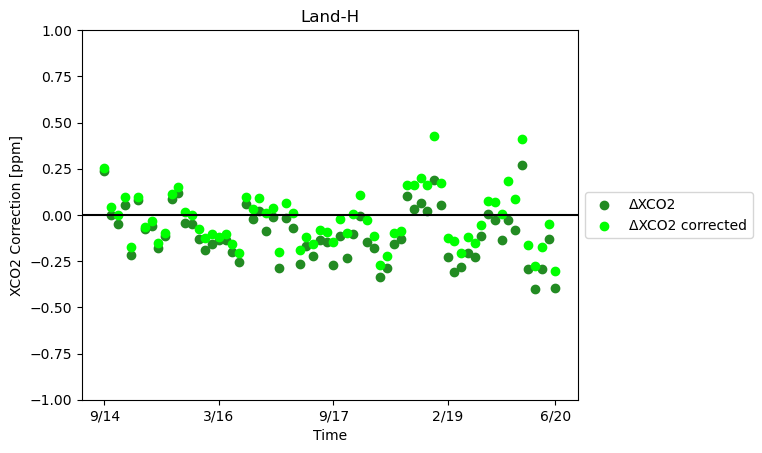

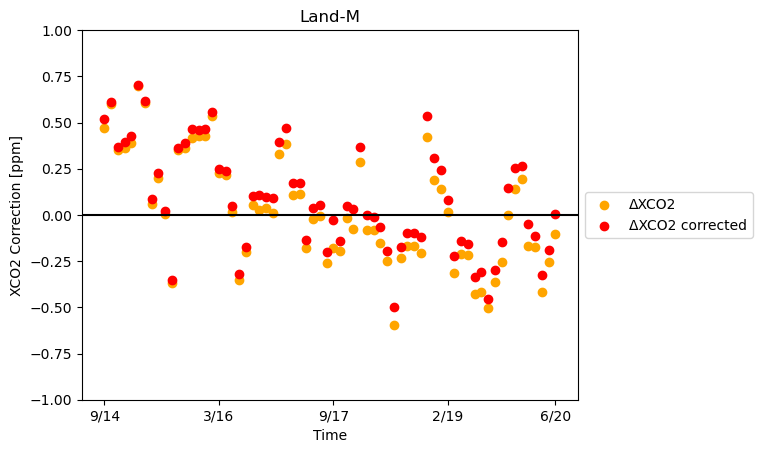

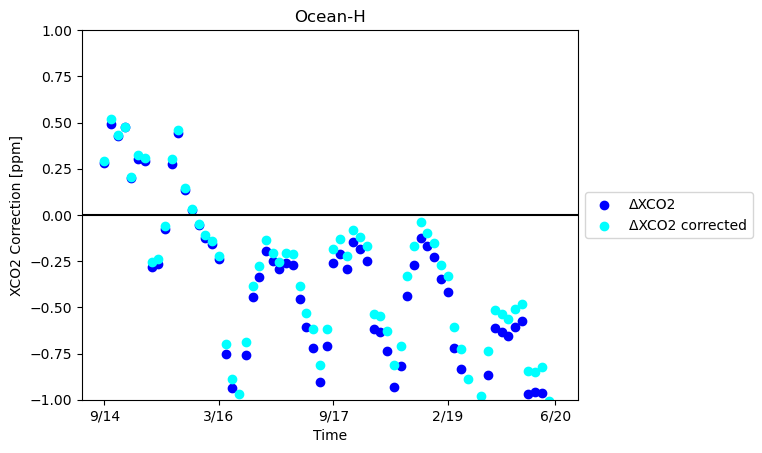

In [63]:
# All modes
"""plt.scatter(xco2_monthly_medians_all_modes.index, xco2_monthly_medians_all_modes['dxco2_monthly_median'].values, label=u'ΔXCO2', color='deeppink')
plt.scatter(xco2_monthly_medians_all_modes.index, xco2_monthly_medians_all_modes['dxco2_corrected_monthly_median'].values, label=u'ΔXCO2 corrected', color='blue')
plt.axhline(0, color='black')

plt.title('All Observation Modes')
plt.xlabel('Time')
plt.ylabel('XCO2 Correction')
plt.xticks([0, 17, 34, 51, 67], ['9/14', '3/16', '9/17', '2/19', '6/20'])
ax = plt.subplot()
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_ylim(-1.0, 1.0)
plt.show()"""

# Land-H
plt.scatter(xco2_monthly_medians_land_h.index, xco2_monthly_medians_land_h['dxco2_monthly_median'].values, label=u'ΔXCO2', color='forestgreen')
plt.scatter(xco2_monthly_medians_land_h.index, xco2_monthly_medians_land_h['dxco2_corrected_monthly_median'].values, label=u'ΔXCO2 corrected', color='lime')
plt.axhline(0, color='black')

plt.title('Land-H')
plt.xlabel('Time')
plt.ylabel('XCO2 Correction [ppm]')
plt.xticks([0, 17, 34, 51, 67], ['9/14', '3/16', '9/17', '2/19', '6/20'])
ax = plt.subplot()
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_ylim(-1.0, 1.0)
plt.show()

# Land-M
plt.scatter(xco2_monthly_medians_land_m.index, xco2_monthly_medians_land_m['dxco2_monthly_median'].values, label=u'ΔXCO2', color='orange')
plt.scatter(xco2_monthly_medians_land_m.index, xco2_monthly_medians_land_m['dxco2_corrected_monthly_median'].values, label=u'ΔXCO2 corrected', color='red')
plt.axhline(0, color='black')

plt.title('Land-M')
plt.xlabel('Time')
plt.ylabel('XCO2 Correction [ppm]')
plt.xticks([0, 17, 34, 51, 67], ['9/14', '3/16', '9/17', '2/19', '6/20'])
ax = plt.subplot()
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_ylim(-1.0, 1.0)
plt.show()

# Ocean-H
plt.scatter(xco2_monthly_medians_ocean_h.index, xco2_monthly_medians_ocean_h['dxco2_monthly_median'].values, label=u'ΔXCO2', color='blue')
plt.scatter(xco2_monthly_medians_ocean_h.index, xco2_monthly_medians_ocean_h['dxco2_corrected_monthly_median'].values, label=u'ΔXCO2 corrected', color='cyan')
plt.axhline(0, color='black')

plt.title('Ocean-H')
plt.xlabel('Time')
plt.ylabel('XCO2 Correction [ppm]')
plt.xticks([0, 17, 34, 51, 67], ['9/14', '3/16', '9/17', '2/19', '6/20'])
ax = plt.subplot()
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_ylim(-1.0, 1.0)
plt.show()

In [92]:
# Bin and take median over AOD versus dxco2
land_h_df = colloc_data_filtered[(colloc_data_filtered['gosat_retrieval_surface_type'] == 1)  & (colloc_data_filtered['gosat_gain'] == b'H')]
land_h_hist, land_h_bin_edges = np.histogram(land_h_df['gosat_retrieval_aod_total'], bins=47)

land_m_df = colloc_data_filtered[(colloc_data_filtered['gosat_retrieval_surface_type'] == 1)  & (colloc_data_filtered['gosat_gain'] == b'M')]
land_m_hist, land_m_bin_edges = np.histogram(land_m_df['gosat_retrieval_aod_total'], bins=7)

ocean_h_df = colloc_data_filtered[(colloc_data_filtered['gosat_retrieval_surface_type'] == 0)  & (colloc_data_filtered['gosat_gain'] == b'H')]
ocean_h_hist, ocean_h_bin_edges = np.histogram(ocean_h_df['gosat_retrieval_aod_total'], bins=26)

In [93]:
# AOD_TOTAL
aod_total_land_h, xco2_land_h, xco2_corr_land_h = [], [], []
for i in range(len(bin_edges)):
  if i == len(bin_edges)-1:
    continue
  else:
    land_h_bin_data = land_h_df[(land_h_df['gosat_retrieval_aod_total'] > bin_edges[i]) & (land_h_df['gosat_retrieval_aod_total'] < bin_edges[i+1])]
  aod_total_land_h += [land_h_bin_data['gosat_retrieval_aod_total'].median()]
  xco2_land_h += [land_h_bin_data['dxco2'].median()]
  xco2_corr_land_h += [land_h_bin_data['dxco2_corrected'].median()]

aod_total_land_m, xco2_land_m, xco2_corr_land_m = [], [], []
for i in range(len(bin_edges)):
  if i == len(bin_edges)-1:
    continue
  else:
    land_m_bin_data = land_m_df[(land_m_df['gosat_retrieval_aod_total'] > bin_edges[i]) & (land_m_df['gosat_retrieval_aod_total'] < bin_edges[i+1])]
  aod_total_land_m += [land_m_bin_data['gosat_retrieval_aod_total'].median()]
  xco2_land_m += [land_m_bin_data['dxco2'].median()]
  xco2_corr_land_m += [land_m_bin_data['dxco2_corrected'].median()]

aod_total_ocean_h, xco2_ocean_h, xco2_corr_ocean_h = [], [], []
for i in range(len(bin_edges)):
  if i == len(bin_edges)-1:
    continue
  else:
    ocear_h_bin_data = ocean_h_df[(ocean_h_df['gosat_retrieval_aod_total'] > bin_edges[i]) & (ocean_h_df['gosat_retrieval_aod_total'] < bin_edges[i+1])]
  aod_total_ocean_h += [ocear_h_bin_data['gosat_retrieval_aod_total'].median()]
  xco2_ocean_h += [ocear_h_bin_data['dxco2'].median()]
  xco2_corr_ocean_h += [ocear_h_bin_data['dxco2_corrected'].median()]

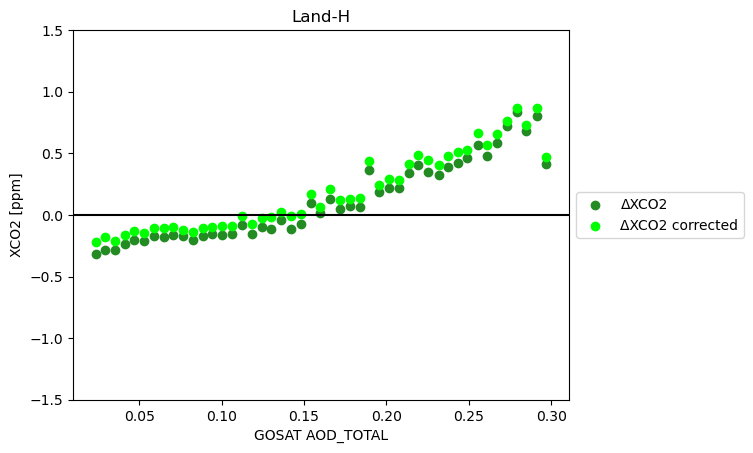

"# Land-M\nplt.scatter(xco2_monthly_medians_land_m.index, xco2_monthly_medians_land_m['dxco2_monthly_median'].values, label=u'ΔXCO2', color='orange')\nplt.scatter(xco2_monthly_medians_land_m.index, xco2_monthly_medians_land_m['dxco2_corrected_monthly_median'].values, label=u'ΔXCO2 corrected', color='red')\nplt.axhline(0, color='black')\n\nplt.title('Land-M')\nplt.xlabel('Time')\nplt.ylabel('XCO2 Correction [ppm]')\nplt.xticks([0, 17, 34, 51, 67], ['9/14', '3/16', '9/17', '2/19', '6/20'])\nax = plt.subplot()\nax.legend(loc='center left', bbox_to_anchor=(1, 0.5))\nax.set_ylim(-1.0, 1.0)\nplt.show()\n\n# Ocean-H\nplt.scatter(xco2_monthly_medians_ocean_h.index, xco2_monthly_medians_ocean_h['dxco2_monthly_median'].values, label=u'ΔXCO2', color='blue')\nplt.scatter(xco2_monthly_medians_ocean_h.index, xco2_monthly_medians_ocean_h['dxco2_corrected_monthly_median'].values, label=u'ΔXCO2 corrected', color='cyan')\nplt.axhline(0, color='black')\n\nplt.title('Ocean-H')\nplt.xlabel('Time')\nplt.yla

In [94]:
# Land-H
plt.scatter(aod_total_land_h, xco2_land_h, label=u'ΔXCO2', color='forestgreen')
plt.scatter(aod_total_land_h, xco2_corr_land_h, label=u'ΔXCO2 corrected', color='lime')
plt.axhline(0, color='black')

plt.title('Land-H')
plt.xlabel('GOSAT AOD_TOTAL')
plt.ylabel('XCO2 [ppm]')
ax = plt.subplot()
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_ylim(-1.5, 1.5)
plt.show()

"""# Land-M
plt.scatter(xco2_monthly_medians_land_m.index, xco2_monthly_medians_land_m['dxco2_monthly_median'].values, label=u'ΔXCO2', color='orange')
plt.scatter(xco2_monthly_medians_land_m.index, xco2_monthly_medians_land_m['dxco2_corrected_monthly_median'].values, label=u'ΔXCO2 corrected', color='red')
plt.axhline(0, color='black')

plt.title('Land-M')
plt.xlabel('Time')
plt.ylabel('XCO2 Correction [ppm]')
plt.xticks([0, 17, 34, 51, 67], ['9/14', '3/16', '9/17', '2/19', '6/20'])
ax = plt.subplot()
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_ylim(-1.0, 1.0)
plt.show()

# Ocean-H
plt.scatter(xco2_monthly_medians_ocean_h.index, xco2_monthly_medians_ocean_h['dxco2_monthly_median'].values, label=u'ΔXCO2', color='blue')
plt.scatter(xco2_monthly_medians_ocean_h.index, xco2_monthly_medians_ocean_h['dxco2_corrected_monthly_median'].values, label=u'ΔXCO2 corrected', color='cyan')
plt.axhline(0, color='black')

plt.title('Ocean-H')
plt.xlabel('Time')
plt.ylabel('XCO2 Correction [ppm]')
plt.xticks([0, 17, 34, 51, 67], ['9/14', '3/16', '9/17', '2/19', '6/20'])
ax = plt.subplot()
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_ylim(-1.0, 1.0)
plt.show()
"""